---
# Import dependecies

In [63]:
import pandas as pd

---
# Work with data

## Preprocess data

In [64]:
df = pd.read_excel("data/train.xlsx", skiprows=5)

In [65]:
df.shape

(314, 148)

In [66]:
df.head(3)

,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли.1","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки",...,Итого.11,"ТВ, trp\n(Ж 30-60 ВС).12","ТВ, охват 5+\n(Ж 30-60 ВС).12","ТВ, рубли.12","Диджитал, руб.12","ТВ спонсорство, рубли.12","OOH, рубли.12","Радио, рубли.13",Итого.12,Unnamed: 147
0,2019.0,1,2018-12-31,4.153557e+07,114621.15,0.0,0.0,0.0,0.0,0.0,...,1.183425e+07,207.903106,15.3615,9085528.010323,0.0,0.0,0.0,0.0,9.085528e+06,NaN
1,NaN,2,2019-01-07,5.122229e+07,141523.20,0.0,0.0,0.0,0.0,0.0,...,1.399653e+07,317.467542,25.5255,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN
2,NaN,3,2019-01-14,5.712735e+07,157926.30,0.0,0.0,0.0,0.0,0.0,...,1.146629e+07,192.816682,13.9125,10599782.67871,0.0,0.0,0.0,0.0,1.059978e+07,NaN


## Split on train/test data sets

In [67]:
df_train = df.iloc[:244]
df_submission = df.iloc[244:]

## Data analisys

In [68]:
import matplotlib.pyplot as plt

In [69]:
eda_cols = ["Продажи, рубли",
            "Продажи, упаковки",
            "Дистрибуция Мирамистин",
            "Выписки ",
            "Статистика заболеваемости",
            "Индекс цены",
            "Запросы Wordstat",
            "Диджитал, рубли",]

In [70]:
data = df_train[eda_cols]

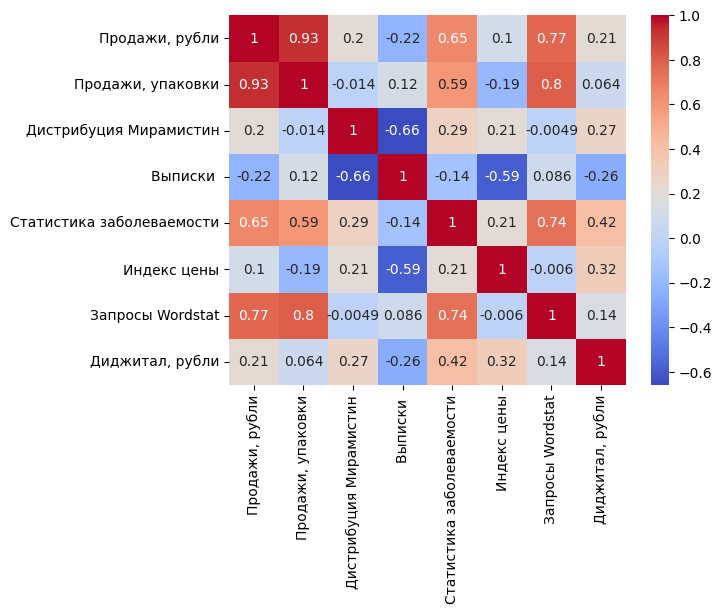

In [71]:
import seaborn as sns

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

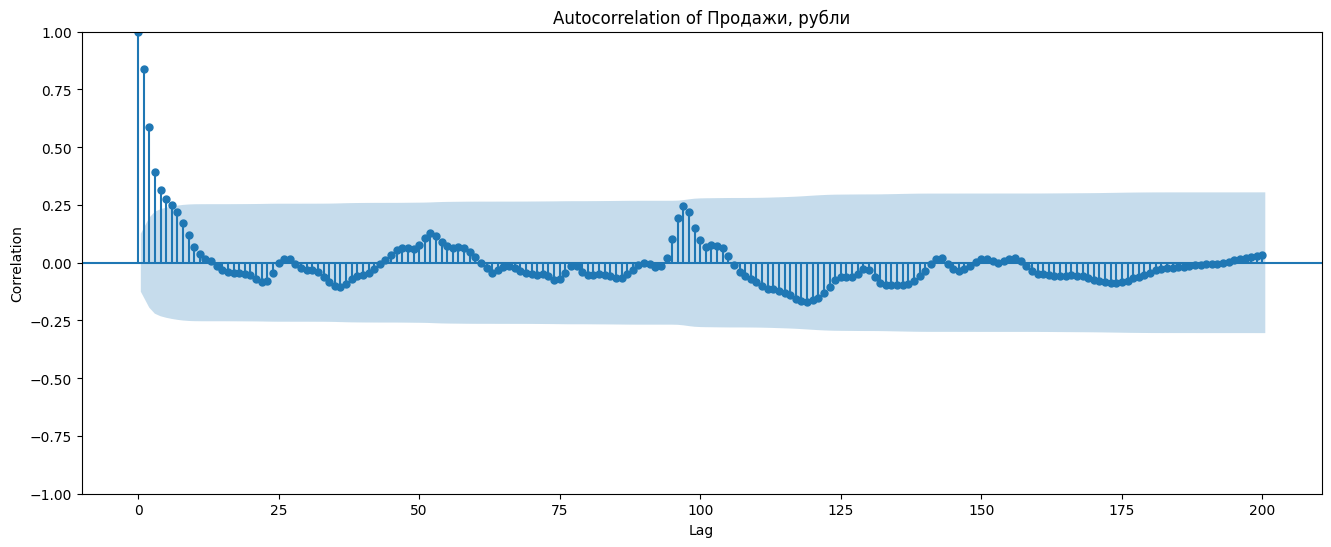

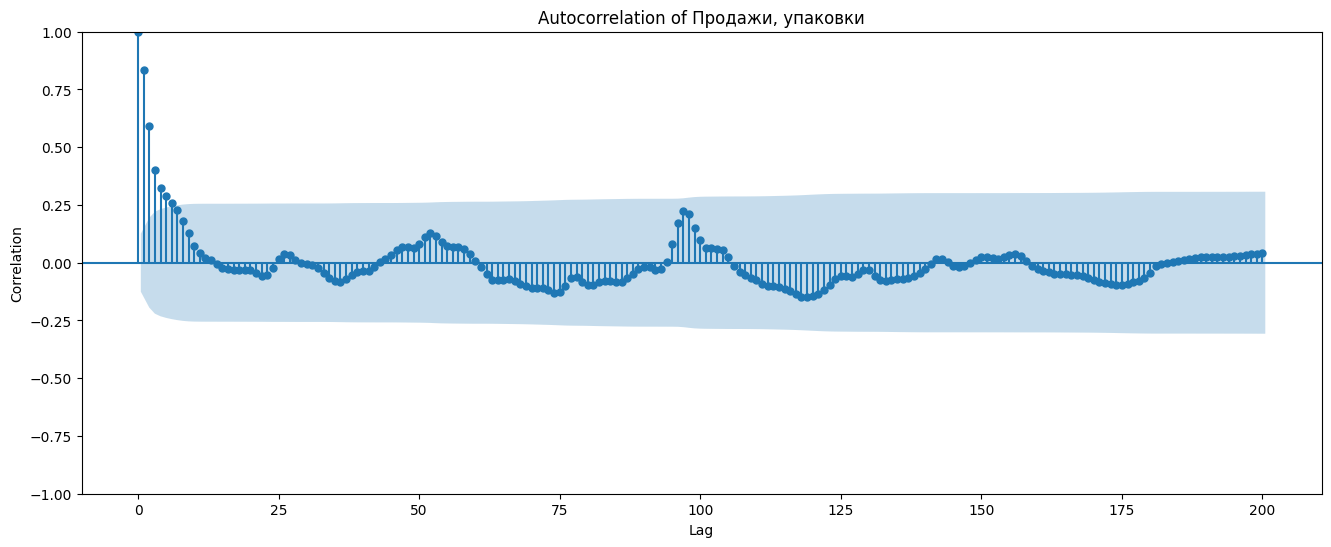

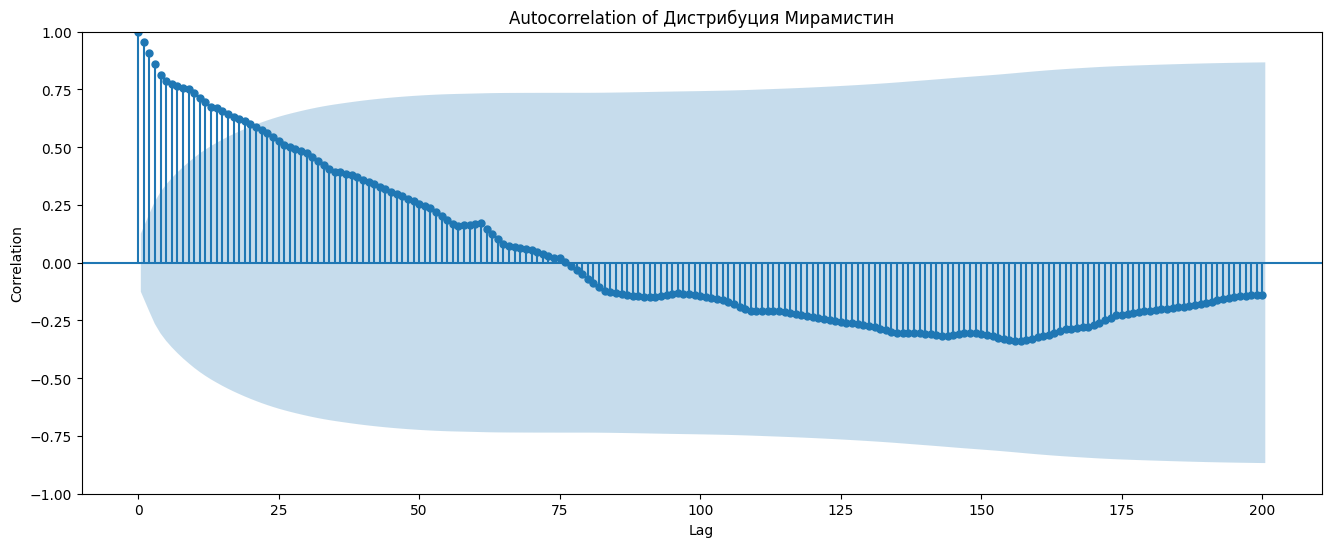

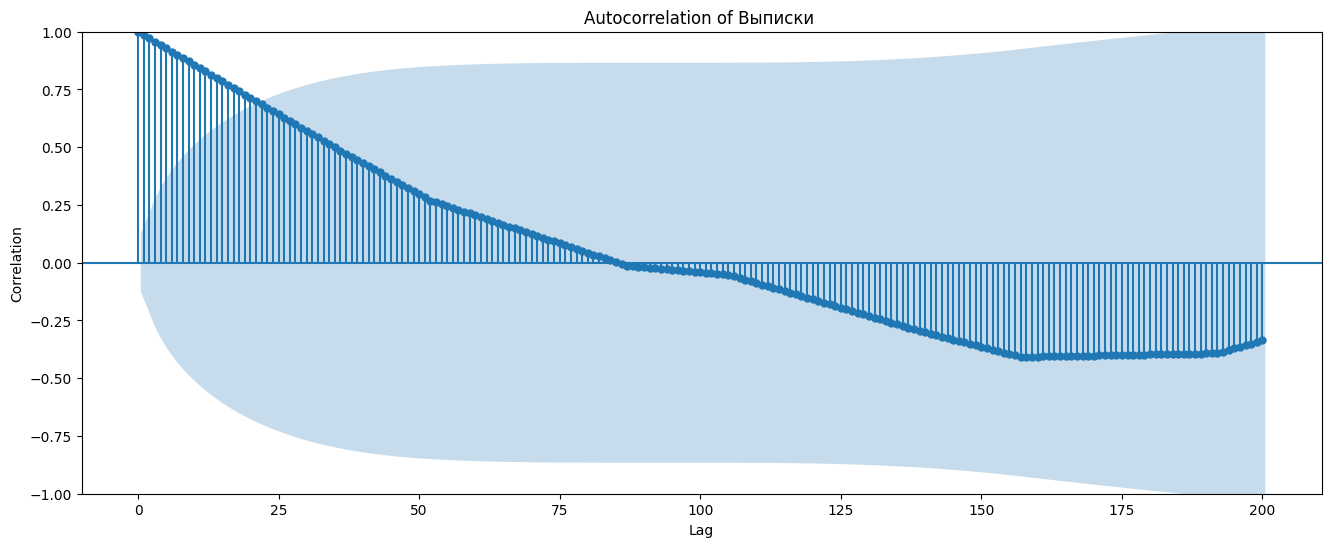

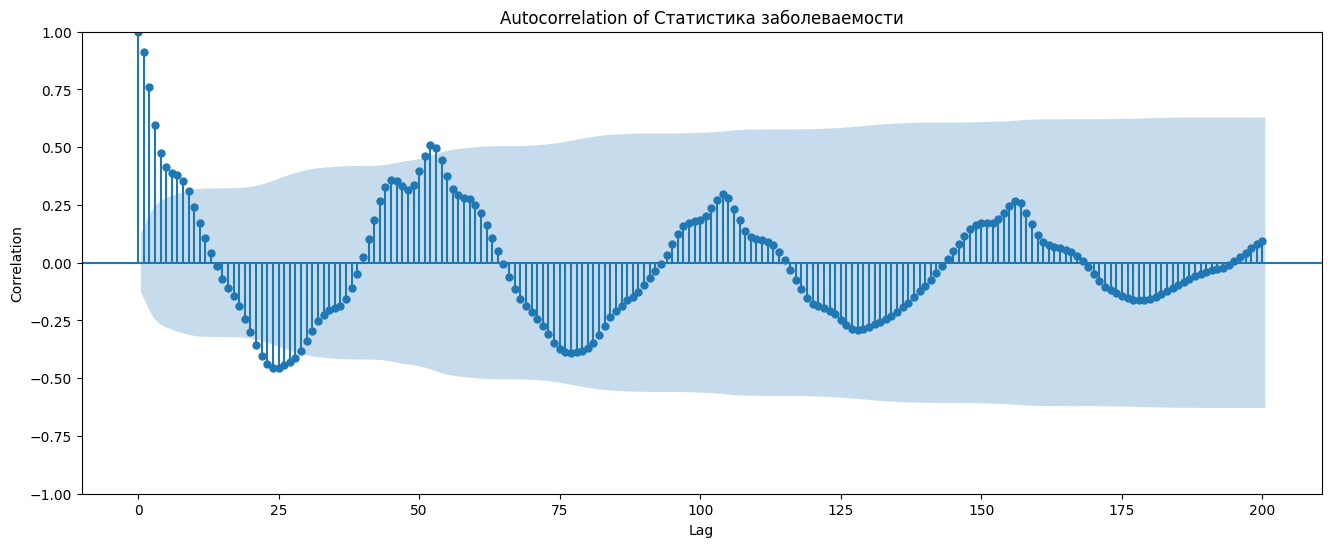

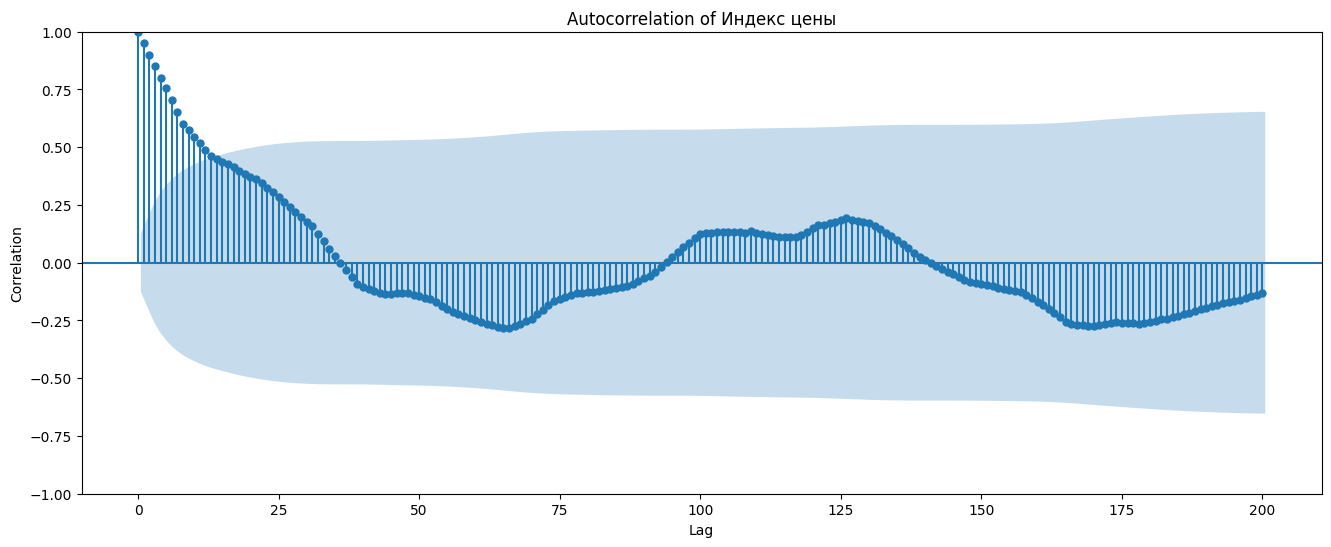

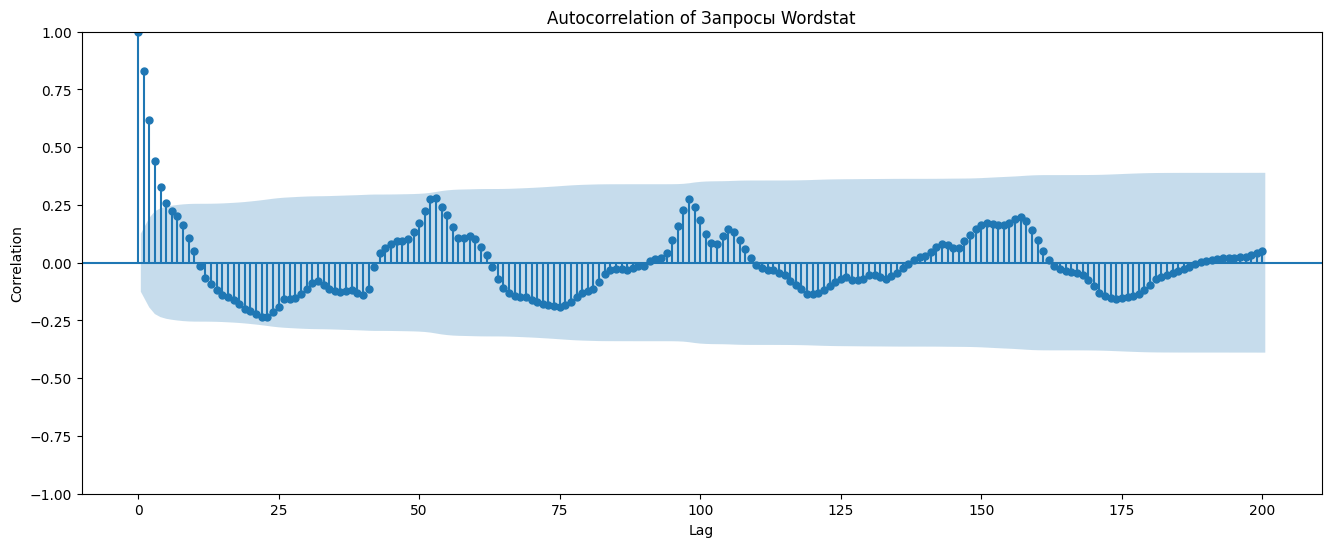

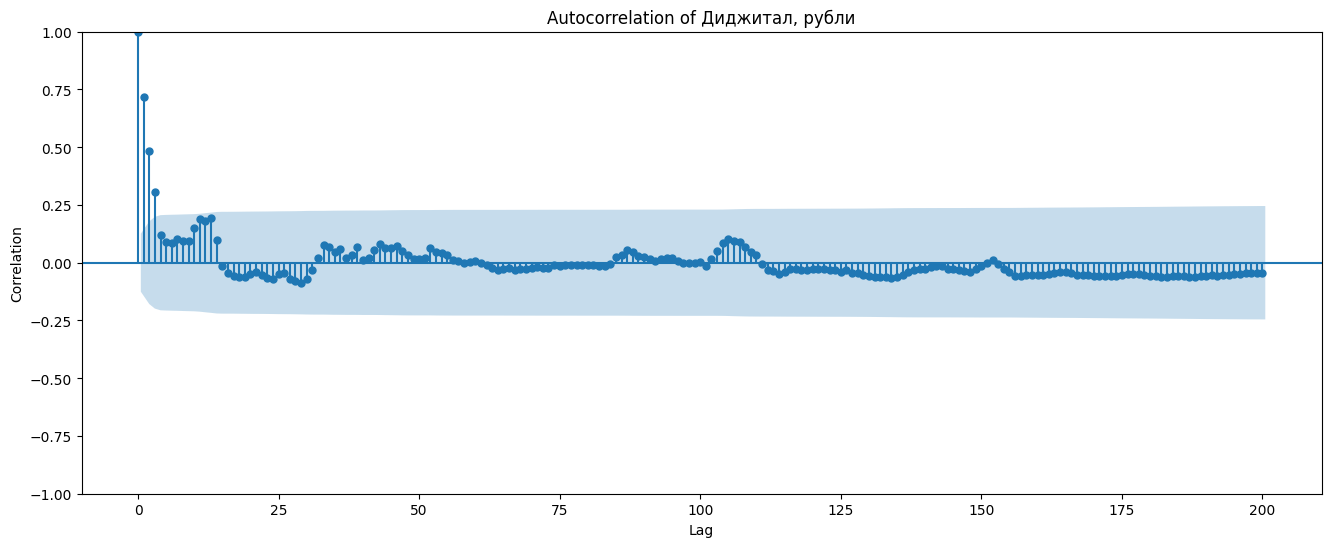

In [72]:
from statsmodels.graphics.tsaplots import plot_acf
for col in data.select_dtypes(include='number').columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    plot_acf(data[col], lags=200, ax=ax)
    ax.set(title=f'Autocorrelation of {col}', xlabel='Lag', ylabel='Correlation')
    plt.show()

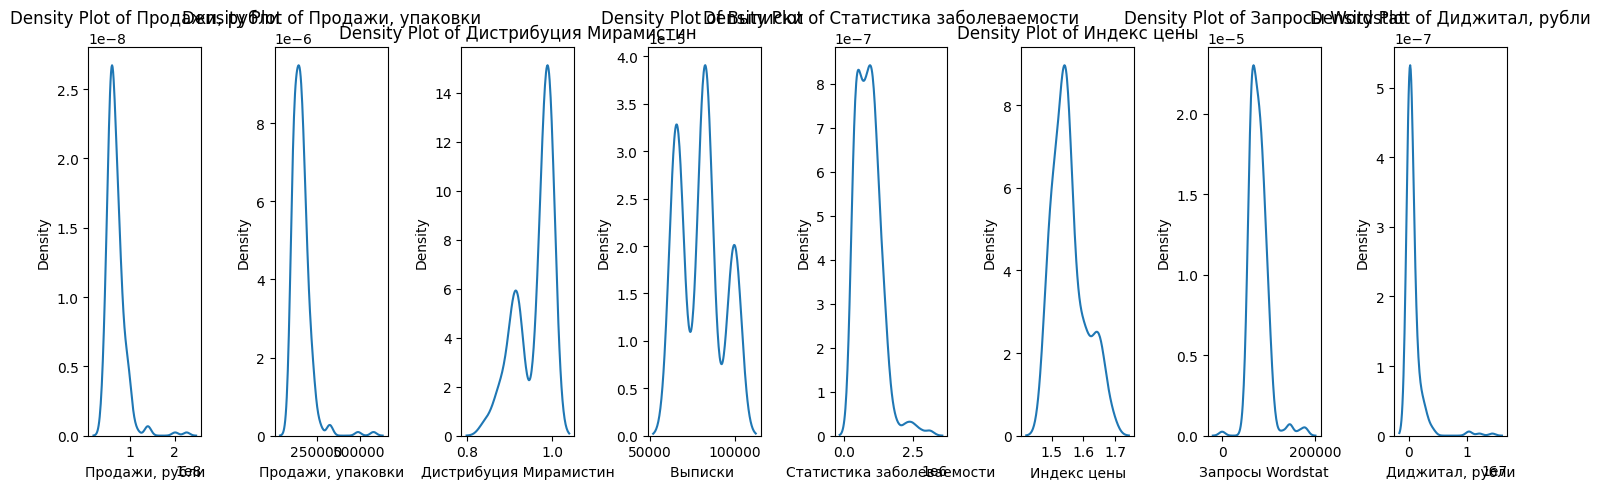

In [73]:
from scipy import stats
numerical_features = data.select_dtypes(include=['float64', 'int64'])
n = 1

fig, axes = plt.subplots(n, len(data.columns), figsize=(15, 5))  # Adjust figsize as needed

for i, col in enumerate(data.columns):
    sns.kdeplot(data=data[col], ax=axes[i])
    axes[i].set_title(f'Density Plot of {col}')

plt.tight_layout()
plt.show()

## Delete outliers

In [74]:
Q1 = df_train['Продажи, рубли'].quantile(0.35)
Q3 = df_train['Продажи, рубли'].quantile(0.75)

print(df_train.shape)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_train = df_train[(df_train['Продажи, рубли'] >= lower_bound) & (df_train['Продажи, рубли'] <= upper_bound)]

print("Filtered DataFrame:")
print(df_train.shape)

(244, 148)
Filtered DataFrame:
(236, 148)


In [75]:
df_train['Продажи, рубли'].describe()

count    2.360000e+02
mean     6.529136e+07
std      1.389616e+07
min      3.953069e+07
25%      5.575626e+07
50%      6.237400e+07
75%      7.321242e+07
max      1.020057e+08
Name: Продажи, рубли, dtype: float64

## Save data

In [49]:
# df_train.to_csv('data/df_train.csv', index=False)
# df_submission.to_csv('data/df_submission.csv', index=False)

---
# Model train 

## Split data

In [76]:
import pandas as pd

data = df_train

non_numeric_features = data.select_dtypes(exclude=['number']).columns.tolist()
# non_numeric_features

In [77]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

data = df_train
X = data.drop(non_numeric_features, axis=1).drop('Продажи, рубли', axis=1).drop('Продажи, упаковки', axis=1)
y = data['Продажи, рубли']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [29]:
import optuna 

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1_000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
    }

    kf = KFold(n_splits=5, shuffle=True)
    mapes = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = RandomForestRegressor(**params,)
        model.fit(X_train_fold, y_train_fold,)
        
        y_pred = model.predict(X_val_fold)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        mapes.append(mape)

    mapes = np.mean(mapes)
    return mapes  

In [30]:
n_trials=25

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2024-04-14 07:49:41,521] A new study created in memory with name: no-name-c2475d50-45c3-4939-b8b7-1e43eadd3ebc
[I 2024-04-14 07:49:46,922] Trial 0 finished with value: 0.058376302299193626 and parameters: {'n_estimators': 602, 'max_depth': 6}. Best is trial 0 with value: 0.058376302299193626.
[I 2024-04-14 07:49:49,713] Trial 1 finished with value: 0.0577525166235897 and parameters: {'n_estimators': 262, 'max_depth': 9}. Best is trial 1 with value: 0.0577525166235897.
[I 2024-04-14 07:49:51,109] Trial 2 finished with value: 0.07158858061820539 and parameters: {'n_estimators': 196, 'max_depth': 4}. Best is trial 1 with value: 0.0577525166235897.
[I 2024-04-14 07:49:55,315] Trial 3 finished with value: 0.07788582231546072 and parameters: {'n_estimators': 693, 'max_depth': 3}. Best is trial 1 with value: 0.0577525166235897.
[I 2024-04-14 07:50:01,289] Trial 4 finished with value: 0.0668430352107486 and parameters: {'n_estimators': 853, 'max_depth': 4}. Best is trial 1 with value: 0.057

In [31]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials:  25
Best trial:
Value:  0.05514476819477221
Params: 
    n_estimators: 428
    max_depth: 7


In [32]:
# params = {
#     "n_estimators": 251,
#     "max_depth": 10 
# }

In [33]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(**trial.params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model using MAPE
y_pred = rf_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error: {mape}')

from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

Mean Absolute Percentage Error: 0.05216415708479323


0.8834536455391269

## XGBoost

In [82]:
import xgboost as xgb

In [80]:
import optuna 

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2_000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'reg_alpha': trial.suggest_int('reg_alpha', 10, 140),
    }


    kf = KFold(n_splits=5, shuffle=True)
    mapes = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        xgb_model = xgb.XGBRegressor(**params, device="cuda")
        xgb_model.fit(X_train_fold, y_train_fold,)
        
        y_pred = xgb_model.predict(X_val_fold)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        mapes.append(mape)

    mapes = np.mean(mapes)
    return mapes  

In [83]:
n_trials=50

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2024-04-14 10:12:08,202] A new study created in memory with name: no-name-8667799b-8f78-41a2-907d-460d88904eab
/home/eresque/anaconda3/envs/PyTorch/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:12:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-04-14 10:12:11,469] Trial 0 finished with value: 0.05998268168969031 and parameters: {'n_estimators': 308, 'max_depth': 10, 'learning_rate': 0.13044788232575505, 'reg_alpha': 68}. Best is trial 0 with value: 0.05998268168969031.
[I 2024-04-14 10:12:18,120] Trial 1 finished with value: 0.04993668

In [85]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials:  50
Best trial:
Value:  0.04993668494636676
Params: 
    n_estimators: 1544
    max_depth: 2
    learning_rate: 0.17008022981889204
    reg_alpha: 139


In [20]:
# params = {
#     "n_estimators": 1593,
#     "max_depth": 2,
#     "learning_rate": 0.1577532714144577,
#     "reg_alpha": 28,
# }

In [86]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


# xgb_model = xgb.XGBRegressor(**params)
xgb_model = xgb.XGBRegressor(**trial.params)


xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error: {mape}')

from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

Mean Absolute Percentage Error: 0.04709457227112083


0.9028140443893837

## Catboost 

In [17]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2_000),
        'depth': trial.suggest_int('depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'loss_function': 'MAPE',
        'verbose': False
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mapes = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = CatBoostRegressor(**params, task_type="GPU", devices='0:1',)
        model.fit(X_train_fold, y_train_fold, early_stopping_rounds=10, verbose=False)
        
        y_pred = model.predict(X_val_fold)
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        mapes.append(mape)

    mapes = np.mean(mapes)
    return mapes  

In [18]:
n_trials=25

In [20]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

/home/eresque/anaconda3/envs/PyTorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-04-14 08:41:56,351] A new study created in memory with name: no-name-4d44ab27-5e84-4180-8524-ad5e7e44d44b
[I 2024-04-14 08:42:08,960] Trial 0 finished with value: 0.1435922121467291 and parameters: {'iterations': 963, 'depth': 4, 'learning_rate': 0.10286276542131813}. Best is trial 0 with value: 0.1435922121467291.
[I 2024-04-14 08:42:13,082] Trial 1 finished with value: 0.14359221214673729 and parameters: {'iterations': 429, 'depth': 5, 'learning_rate': 0.024695298386224144}. Best is trial 0 with value: 0.1435922121467291.
[I 2024-04-14 08:42:35,165] Trial 2 finished with value: 0.1435922121467354 and parameters: {'iterations': 1464, 'depth': 5, 'learning_rate': 0.01869001170893029}. Best is trial 0 with value:

In [ ]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [29]:
# y_pred

---
# Save model

In [87]:
import joblib
joblib.dump(xgb_model, 'model/model_xgb.joblib')   

['model/model_xgb.joblib']

---
# Create submission

## Load data

In [94]:
df_submission = pd.read_csv('data/df_submission_added.csv')
df_submission.head(3)

,Unnamed: 0,год,неделя,Начало нед,"Продажи, рубли","Продажи, упаковки","Продажи, рубли.1","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб",...,Итого.11,"ТВ, trp\n(Ж 30-60 ВС).12","ТВ, охват 5+\n(Ж 30-60 ВС).12","ТВ, рубли.12","Диджитал, руб.12","ТВ спонсорство, рубли.12","OOH, рубли.12","Радио, рубли.13",Итого.12,Unnamed: 147
0,0,NaN,36,2023-09-04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,37,2023-09-11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,38,2023-09-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Predict data

In [95]:
df_submission['Запросы Wordstat'] = pd.to_numeric(df_submission['Запросы Wordstat'], errors='coerce')
df_submission['Продажи, рубли'] = xgb_model.predict(df_submission.drop(non_numeric_features, axis=1).drop('Продажи, рубли', axis=1).drop(['Продажи, упаковки', 'Unnamed: 0'], axis=1))

In [96]:
df_submission = df_submission[['Начало нед', 'Продажи, рубли']]
df_submission.rename(columns={'Начало нед': 'week', 'Продажи, рубли': 'revenue'}, inplace=True)

# Save data

In [97]:
df_submission = df_submission.iloc[:29]
df_submission.to_csv('data/submission/submission_xgb_added_noout_3.csv', index=False)

# Remake submission

In [98]:
template = pd.read_csv("data/sample_submission.csv")
subm_df = pd.read_csv("data/submission/submission_xgb_added_noout_3.csv")

In [99]:
template["revenue"] = subm_df['revenue']

In [100]:
template.head()

,week,revenue
0,04.09.2023,78713330.0
1,11.09.2023,78272520.0
2,18.09.2023,78256200.0
3,25.09.2023,78256200.0
4,02.10.2023,78697130.0


In [101]:
template.to_csv("data/fixxed_submission/template_4.csv", index=False)